In [91]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.preprocessing import  StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering, KMeans,MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Data Preprocess

In [ ]:
data = pd.read_csv('NOVAIMS_MAA_2020e21_BusinessCasesDataScience_MindOverData_RetailChallenge.csv')

In [ ]:
data.head()

In [ ]:
data['Measures'].value_counts()

In [ ]:
len(data['ProductFamily_ID'].unique())

In [ ]:
len(data['ProductCategory_ID'].unique())

In [ ]:
len(data['ProductBrand_ID'].unique())

In [ ]:
len(data['ProductName_ID'].unique())

In [ ]:
len(data['ProductPackSKU_ID'].unique())

In [ ]:
len(data['Point-of-Sale_ID'].unique())

In [ ]:
data.info()

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d', errors='ignore')

In [ ]:
data.info()

In [ ]:
unit_df = data[data['Measures']=='Sell-out units'].copy()
value_df = data[data['Measures']=='Sell-out values'].copy()

In [ ]:
df_units = data[data["Measures"] == "Sell-out units"]

In [ ]:
df_value = data[data["Measures"] == "Sell-out values"]

In [ ]:
df_value["Units"] = df_units["Value"].values

In [ ]:
data = df_value.drop("Measures", axis=1)

In [ ]:
data['ProductFamily_ID'] = data['ProductFamily_ID'].str.split('_').str[1]

In [ ]:
data['ProductCategory_ID'] = data['ProductCategory_ID'].str.split('_').str[1]

In [ ]:
data['ProductBrand_ID'] = data['ProductBrand_ID'].str.split('_').str[1]

In [ ]:
data['ProductName_ID'] = data['ProductName_ID'].str.split('_').str[1]

In [ ]:
#data['ProductPackSKU_ID'] = data['ProductPackSKU_ID'].str.split('_').str[1]

In [ ]:
data.head()

In [ ]:
data['Point-of-Sale_ID'] = data['Point-of-Sale_ID'].str.split('_').str[1]

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
data.to_csv('data_preprocess.csv')

# New Data Set 

In [2]:
data = pd.read_csv('data_preprocess.csv')

In [3]:
data.drop('Unnamed: 0',inplace=True,axis=1)

In [4]:
data.head()

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Value,Day of the Week,Quarter,Units
0,16,11,306,649,1970,1,2017-03-04,1540.0,5,1,2.0
1,16,11,306,649,1970,1,2016-05-02,3080.0,0,2,4.0
2,16,11,306,649,1970,1,2016-10-24,1540.0,0,4,2.0
3,16,11,306,649,1970,1,2017-10-13,1620.0,4,4,2.0
4,16,11,306,649,1970,1,2017-10-14,1620.0,5,4,2.0


# Clustering

### Functions 

In [118]:
def plot_R2(df,column):
    sst =  get_ss(df)
    df_concat = pd.concat((df, pd.Series(column, name='label')), axis=1)  # concat df with labels
    ssw_labels = df_concat.groupby(by='label').apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)   # remember: SST = SSW + SSB
    return ssb / sst

In [5]:
def plotKElbow(cluster,data,metric):
    visualizer = KElbowVisualizer(cluster, k=(2,12), metric=metric, timings=False,locate_elbowbool=False)
    visualizer.fit(data)        
    visualizer.show()   
    

In [6]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) #get cluster labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

In [7]:
def kmeans_cluster(df,n_clust):
    kmclust = KMeans(n_clusters=n_clust, init='k-means++', n_init=15, random_state=1)
    df_labels = kmclust.fit_predict(df)
    return df_labels


In [8]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        #ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [9]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

In [10]:
def avg_silhouette(min_range,max_range,df,cluster):
    avg_silhouette = []
    for nclus in range(min_range,max_range):
        # Skip nclus == 1
        if nclus == 1:
            continue
    
        # Create a figure
        fig = plt.figure(figsize=(10,5 ))

        if "n_clusters" in cluster.get_params():
            param = "n_clusters"
        else:
            param = "n_components"
        
        
        # Get the cluster labels by applying a given clustering algorithm
        clustering = cluster.set_params(**{param:nclus})
        cluster_labels = clustering.fit_predict(df)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, cluster_labels)

        y_lower = 10
        for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
            color = cm.nipy_spectral(float(i) / nclus)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.title("The silhouette plot for the various clusters.")
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label") 

    # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
        xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
        plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(df) + (nclus + 1) * 10])

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks(np.arange(xmin, xmax, 0.1))

In [11]:
def gmm_cluster(data, nclust):
    gmm=GaussianMixture(n_components=nclust, init_params='kmeans', random_state=0)
    gmm.fit(data)
    clust_labels = gmm.predict(data)
    return(clust_labels)

# Value 

In [12]:
data_to_df = {'Total Sales':data.groupby(['Point-of-Sale_ID'])['Value'].sum().values, 'Average Sales': data.groupby(['Point-of-Sale_ID'])['Value'].mean().values}

In [13]:
cluster_value = pd.DataFrame(data = data_to_df, index= data['Point-of-Sale_ID'].unique())
cluster_value

,Total Sales,Average Sales
1,9.786703e+08,5138.456105
2,6.355349e+08,3532.672899
3,1.048120e+09,3813.787357
4,1.261300e+09,3277.568900
5,6.681779e+08,2883.619380
...,...,...
406,7.867554e+08,4010.170513
407,1.264067e+09,4482.092875
408,7.078634e+08,3811.926986
409,7.192561e+08,3912.785665


### Standardaization


In [21]:
scaler = StandardScaler().fit(cluster_value)
standard_value=pd.DataFrame(scaler.transform(cluster_value),index=cluster_value.index, columns=cluster_value.columns)

### KMEANS

In [20]:
standard_value

,Total Sales,Average Sales
1,0.558739,2.161389
2,-0.417811,0.082312
3,0.756391,0.446283
4,1.363093,-0.247982
5,-0.324910,-0.758045
...,...,...
406,0.012557,0.700549
407,1.370966,1.311567
408,-0.211967,0.443875
409,-0.179544,0.574461


In [15]:
cluster = KMeans(random_state=0)

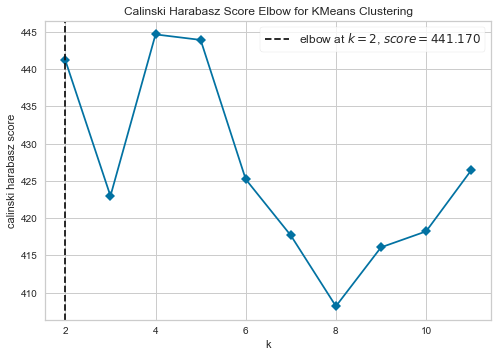

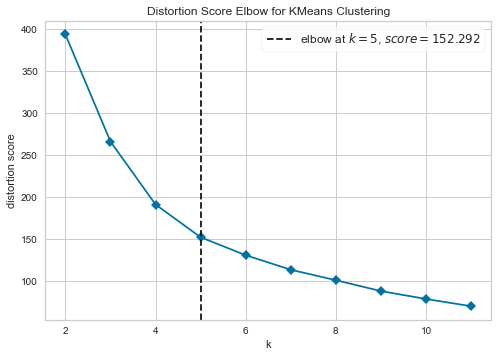

In [23]:
plotKElbow(cluster,standard_value,'calinski_harabasz')
plotKElbow(cluster,standard_value,'distortion')

In [66]:
kmeans_value=standard_value.copy()

In [67]:
kmeans_value['kmeans_label']= kmeans_cluster(kmeans_value,4)

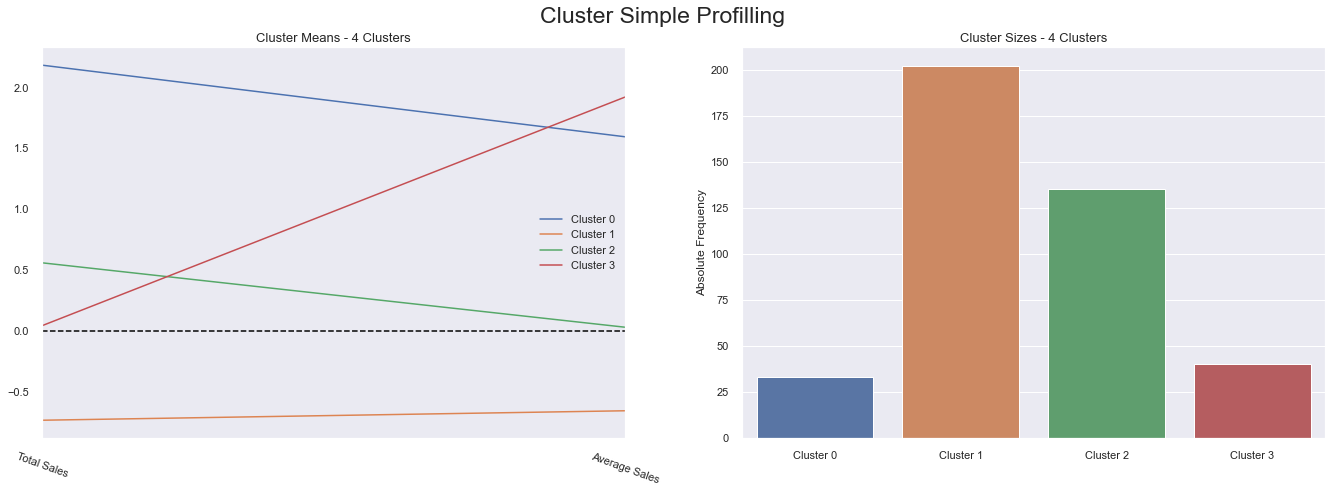

In [68]:
cluster_profiles(kmeans_value, ["kmeans_label"], figsize=(23, 7), compar_titles=["K-Means - All Data"])

### MiniBatchKMeans


In [69]:
MiniBatch = MiniBatchKMeans(n_clusters=None,random_state=0)

C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\b

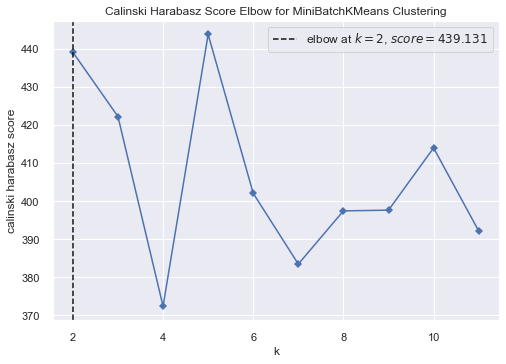

C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\b

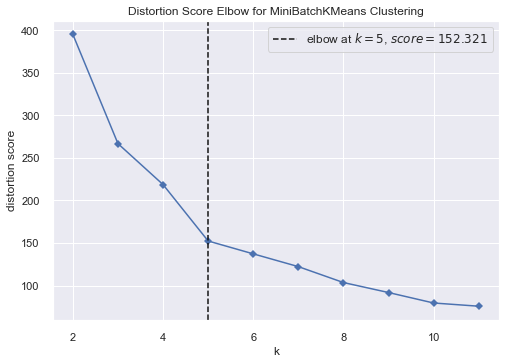

In [70]:
plotKElbow(MiniBatch,standard_value,'calinski_harabasz')
plotKElbow(MiniBatch,standard_value,'distortion')

In [81]:
miniBatch = MiniBatchKMeans(n_clusters=4, init='k-means++', n_init=15, random_state=1)
miniBatch_labels = miniBatch.fit_predict(standard_value)

C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [137]:
miniBatch_value=standard_value.copy()
miniBatch_value['miniBatch_labels']=miniBatch_labels

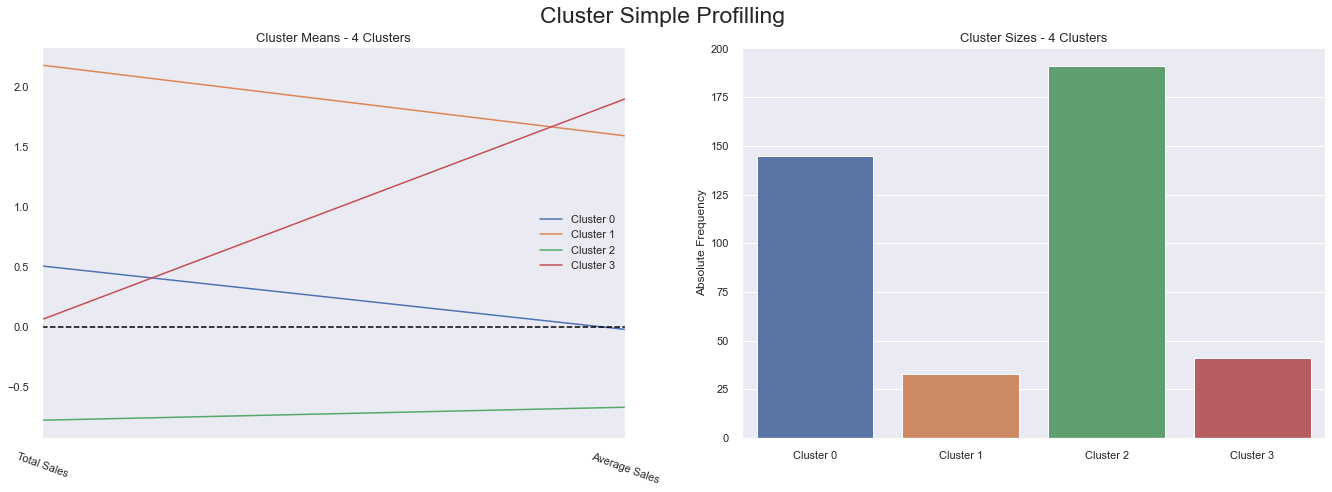

In [138]:
cluster_profiles(miniBatch_value,["miniBatch_labels"], figsize=(23, 7),compar_titles=["MiniBatchKMeans Clustering"])

### GMM


In [139]:
gmm_value = standard_value.copy()
gmm = GaussianMixture(init_params='kmeans', random_state=0)

For n_clusters = 2, the average silhouette_score is : 0.4710602439703446
For n_clusters = 3, the average silhouette_score is : 0.3616000072719925
For n_clusters = 4, the average silhouette_score is : 0.4106521743246671
For n_clusters = 5, the average silhouette_score is : 0.29348847890180024


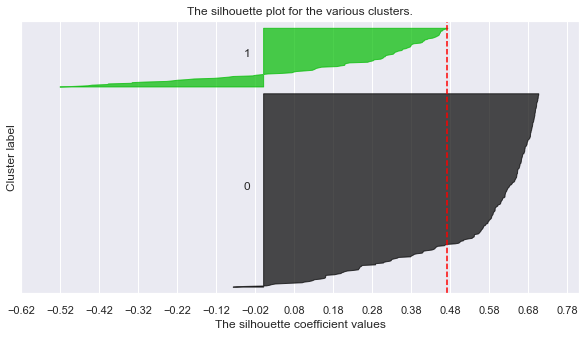

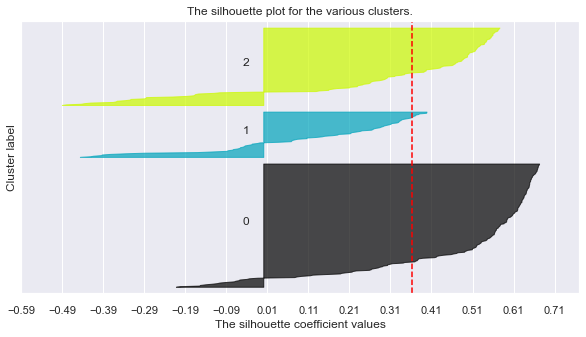

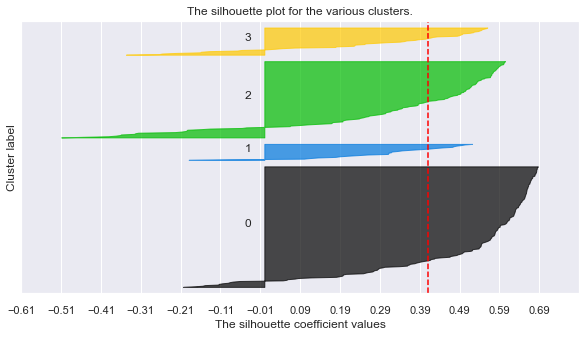

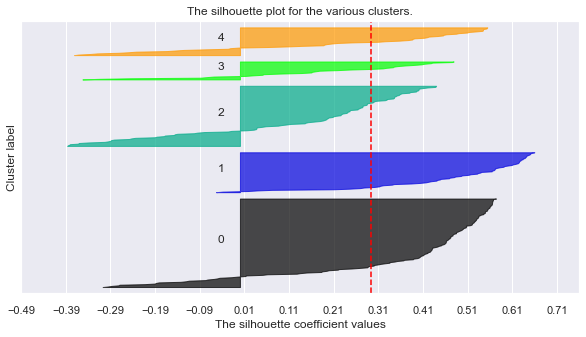

In [140]:
avg_silhouette(2,6,gmm_value,gmm)

In [141]:
gmm_value['gmm_label']=gmm_cluster(gmm_value, 4)

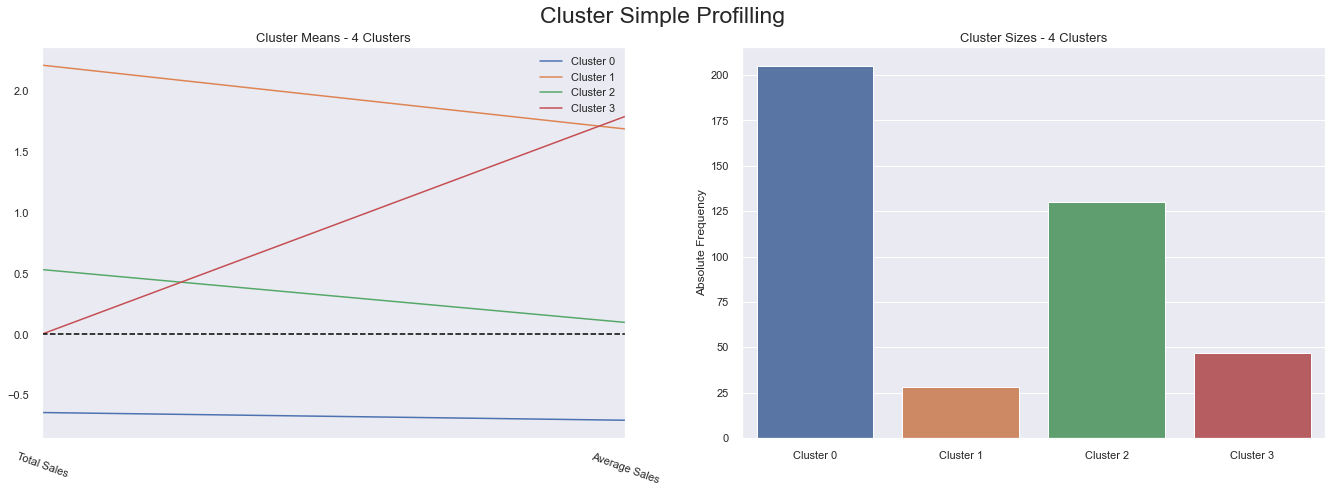

In [142]:
cluster_profiles(gmm_value, ["gmm_label"], figsize=(23, 7), compar_titles=[ "GMM - All Data"])

### HC

In [143]:
hc_value = standard_value.copy()

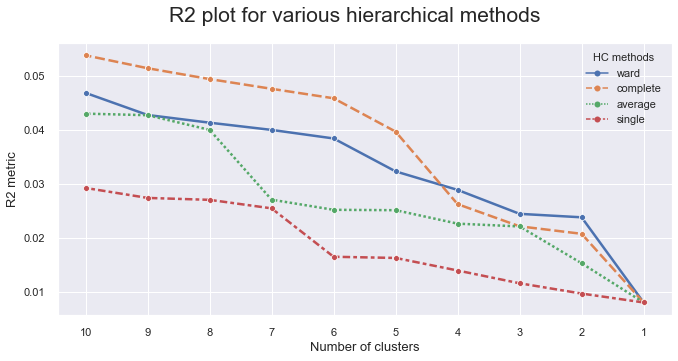

In [144]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(hc_value, link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [145]:
linkage = 'complete'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclabel=hclust.fit_predict(hc_value)

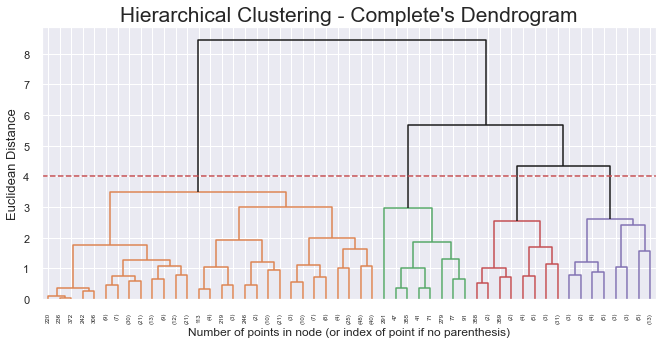

In [146]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 4
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [147]:
hierclust = AgglomerativeClustering(n_clusters=4, linkage='complete')
hclabel=hierclust.fit_predict(hc_value)

In [148]:
hc_value['hc_labels']= hclabel

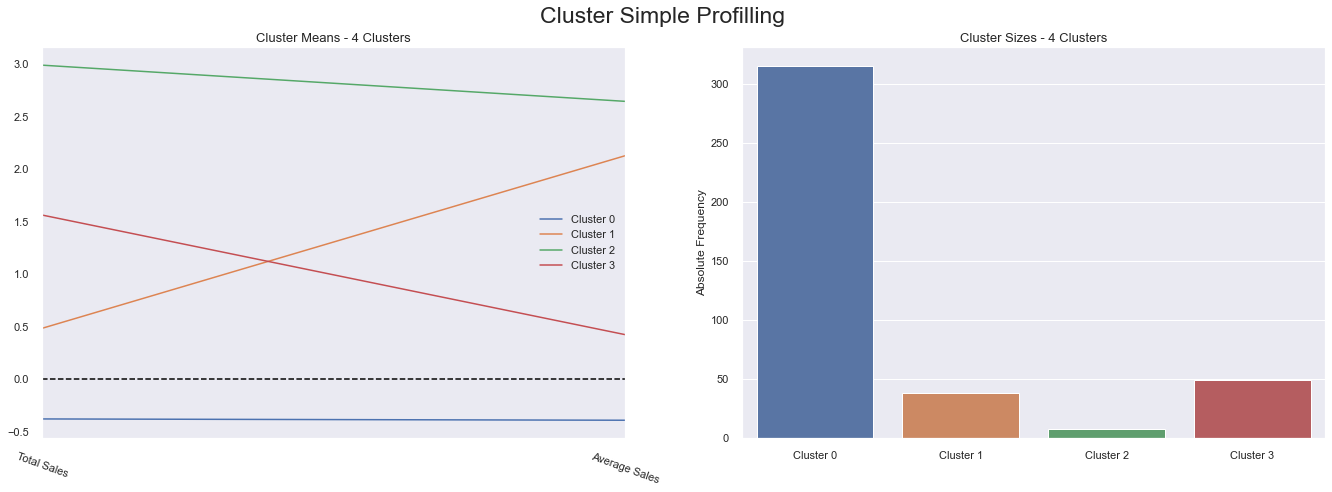

In [149]:
cluster_profiles(hc_value,["hc_labels"], figsize=(23, 7),compar_titles=["HC - Value"])

### R2 Avaliation By Value


In [152]:
r2_kmeans = plot_R2(kmeans_value, kmeans_value['kmeans_label'])
r2_gmm = plot_R2(gmm_value,gmm_value['gmm_label'])
r2_hc = plot_R2(hc_value, hc_value['hc_labels'])
r2_miniBatch = plot_R2(miniBatch_value, miniBatch_value['miniBatch_labels'])

In [154]:
r2_solutions = [r2_kmeans,r2_miniBatch,r2_hc,r2_gmm]
r2_solutions = np.asarray(r2_solutions)

<AxesSubplot:xlabel='Value', ylabel='Col'>

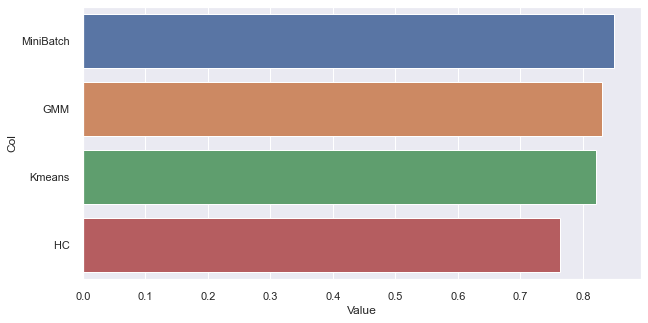

In [155]:
zippy = pd.DataFrame(zip(r2_solutions))
zippy['col'] = [ 'Kmeans', 'MiniBatch', ' HC', 'GMM']
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(10,5))
sns.barplot(y='Col', x='Value', data=tidy)

# Product Preferences

In [166]:
data.groupby(['Point-of-Sale_ID','ProductName_ID'],sort=True)['ProductName_ID'].count()

Point-of-Sale_ID  ProductName_ID
1                 4                    6
                  5                    8
                  6                   10
                  14                 226
                  15                   9
                                    ... 
410               2841               358
                  2845               929
                  2846               977
                  2847              1380
                  2849                 2
Name: ProductName_ID, Length: 485183, dtype: int64

In [169]:
data.groupby(['Point-of-Sale_ID','ProductFamily_ID'],sort=True)['ProductFamily_ID'].count()

Point-of-Sale_ID  ProductFamily_ID
1                 1                   32459
                  2                   10585
                  3                    2762
                  4                     237
                  5                    1512
                                      ...  
410               17                    141
                  18                   9452
                  19                    332
                  20                    607
                  21                  54612
Name: ProductFamily_ID, Length: 8610, dtype: int64

In [182]:
data.head()

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Value,Day of the Week,Quarter,Units
0,16,11,306,649,1970,1,2017-03-04,1540.0,5,1,2.0
1,16,11,306,649,1970,1,2016-05-02,3080.0,0,2,4.0
2,16,11,306,649,1970,1,2016-10-24,1540.0,0,4,2.0
3,16,11,306,649,1970,1,2017-10-13,1620.0,4,4,2.0
4,16,11,306,649,1970,1,2017-10-14,1620.0,5,4,2.0


In [194]:
cluster_product=pd.pivot_table(data,index=["Point-of-Sale_ID"],values=["Units"],
               columns=["ProductName_ID"],aggfunc=[np.sum])

In [199]:
cluster_product.replace(np.nan,0,inplace=True)

In [200]:
cluster_product

sum                                                    ...  \
                 Units                                                    ...   
ProductName_ID    1    2     3     4     5      6    7    8    9    10    ...   
Point-of-Sale_ID                                                          ...   
1                  0.0  0.0   0.0  12.0  17.0   20.0  0.0  0.0  0.0  0.0  ...   
2                  0.0  0.0   1.0  10.0   2.0   19.0  0.0  0.0  0.0  0.0  ...   
3                  0.0  1.0   1.0   4.0   3.0    3.0  0.0  0.0  4.0  0.0  ...   
4                  0.0  5.0  20.0  57.0  13.0  145.0  1.0  1.0  4.0  0.0  ...   
5                  0.0  0.0   3.0   0.0   0.0    4.0  0.0  1.0  2.0  0.0  ...   
...                ...  ...   ...   ...   ...    ...  ...  ...  ...  ...  ...   
406                0.0  0.0   0.0   0.0   0.0    6.0  0.0  0.0  0.0  0.0  ...   
407                0.0  0.0   0.0   2.0   0.0   11.0  0.0  0.0  0.0  0.0  ...   
408                0.0  0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  0.0  ...   
409                0.0  0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  0.0  ...   
410                0.0  1.0   1.0   6.0   1.0    7.0  0.0  0.0  0.0  0.0  ...   

                                                                              \
                                                                               
ProductName_ID      2841 2842 2843 2844    2845    2846    2847   2848  2849   
Point-of-Sale_ID                                                               
1                  785.0  0.0  0.0  0.0  1039.0  1530.0  1782.0   30.0  37.0   
2                  508.0  0.0  0.0  0.0   297.0   345.0  3274.0   77.0  28.0   
3                  531.0  0.0  0.0  0.0  1021.0   759.0  4553.0  269.0   0.0   
4                 1770.0  0.0  0.0  1.0  1835.0  1903.0  7163.0  112.0  25.0   
5                  734.0  0.0  0.0  0.0   781.0   643.0  3533.0   42.0  40.0   
...                  ...  ...  ...  ...     ...     ...     ...    ...   ...   
406                 43.0  0.0  0.0  0.0   446.0   210.0  4338.0    0.0   2.0   
407                159.0  0.0  0.0  0.0  1800.0   784.0  8886.0    0.0   1.0   
408               1153.0  0.0  0.0  0.0   606.0   477.0  7378.0    0.0   0.0   
409                 66.0  0.0  0.0  0.0   960.0   566.0  2843.0    0.0   0.0   
410                712.0  0.0  0.0  0.0  2879.0  2044.0  4831.0    0.0   2.0   

                        
                        
ProductName_ID    2850  
Point-of-Sale_ID        
1                 20.0  
2                  1.0  
3                 43.0  
4                 29.0  
5                  9.0  
...                ...  
406               49.0  
407               17.0  
408                0.0  
409                0.0  
410                0.0  

[410 rows x 2820 columns]

In [207]:
cluster_product.columns= cluster_product.columns.droplevel(0)

In [209]:
cluster_product.columns.name = None        

In [219]:
cluster_product=pd.DataFrame(cluster_product.to_records())

In [222]:
cluster_product.set_index('Point-of-Sale_ID',inplace=True)

In [229]:
cluster_product

,"('Units', 1)","('Units', 2)","('Units', 3)","('Units', 4)","('Units', 5)","('Units', 6)","('Units', 7)","('Units', 8)","('Units', 9)","('Units', 10)",...,"('Units', 2841)","('Units', 2842)","('Units', 2843)","('Units', 2844)","('Units', 2845)","('Units', 2846)","('Units', 2847)","('Units', 2848)","('Units', 2849)","('Units', 2850)"
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,12.0,17.0,20.0,0.0,0.0,0.0,0.0,...,785.0,0.0,0.0,0.0,1039.0,1530.0,1782.0,30.0,37.0,20.0
2,0.0,0.0,1.0,10.0,2.0,19.0,0.0,0.0,0.0,0.0,...,508.0,0.0,0.0,0.0,297.0,345.0,3274.0,77.0,28.0,1.0
3,0.0,1.0,1.0,4.0,3.0,3.0,0.0,0.0,4.0,0.0,...,531.0,0.0,0.0,0.0,1021.0,759.0,4553.0,269.0,0.0,43.0
4,0.0,5.0,20.0,57.0,13.0,145.0,1.0,1.0,4.0,0.0,...,1770.0,0.0,0.0,1.0,1835.0,1903.0,7163.0,112.0,25.0,29.0
5,0.0,0.0,3.0,0.0,0.0,4.0,0.0,1.0,2.0,0.0,...,734.0,0.0,0.0,0.0,781.0,643.0,3533.0,42.0,40.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,43.0,0.0,0.0,0.0,446.0,210.0,4338.0,0.0,2.0,49.0
407,0.0,0.0,0.0,2.0,0.0,11.0,0.0,0.0,0.0,0.0,...,159.0,0.0,0.0,0.0,1800.0,784.0,8886.0,0.0,1.0,17.0
408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1153.0,0.0,0.0,0.0,606.0,477.0,7378.0,0.0,0.0,0.0
